In [2]:
## This is the default setuo for both our mono and both species

%reset -f 

In [3]:
import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [4]:
# load the models 
base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'
base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

# Relax ATP maintenance reactions
# for m in [base1, base2]:
#     for rxn in m.reactions:
#         if rxn.id.upper().startswith("ATPM"):
#             rxn.lower_bound = 0.0

# Set default bounds for all exchanges
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0

# Define media metabolites 
trace_metabolites = [      
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]',  'leu_L[e]', 'hxan[e]','glyglu[e]',
]

media_mets = ['glc_D[e]', 'nh4[e]'] + trace_metabolites

# Define lb_media 
lb_media = {
    "glc_D[e]": 10.0,     
    "nh4[e]":   20.0,
    #"ser_L[e]": 10.0,
}

# Create metabolite to exchange reaction mappings
met_to_ex1 = {}
for rxn in base1.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex1[met.id] = rxn.id

met_to_ex2 = {}
for rxn in base2.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex2[met.id] = rxn.id

# Union of all external metabolites
all_ext_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())


#  COMETS issue workaround: (FIXED)
#Function to add missing closed exchanges
def add_missing_closed_exchanges(model, met_to_ex_self_real, all_ext_mets, label):
    '''
    For each external metabolite in all_ext_mets that this model doesn't have
    a REAL exchange for, add a CLOSED dummy exchange reaction:
        EX_added_<met_id>: met[e] -> with LB = 0, UB = 0.
    '''
    met_ids = {m.id for m in model.metabolites}
    rxn_ids = {r.id for r in model.reactions}

    for met_id in all_ext_mets:
        if met_id in met_to_ex_self_real:
            continue  # this model already has a real exchange for this metabolite

        # Ensure external metabolite exists in the model
        if met_id in met_ids:
            met = model.metabolites.get_by_id(met_id)
        else:
            met = cb.Metabolite(met_id, compartment='e')
            model.add_metabolites([met])
            met_ids.add(met_id)
            print(f"[{label}] Added external metabolite {met_id}")

        # Create a closed dummy exchange reaction if it doesn't exist
        rxn_id = f"EX_added_{met_id}"
        if rxn_id in rxn_ids:
            continue

        rxn = cb.Reaction(rxn_id)
        rxn.name = f"Dummy exchange for {met_id} (closed)"
        rxn.lower_bound = 0.0  # CLOSED by default
        rxn.upper_bound = 0.0  # no secretion either
        rxn.add_metabolites({met: -1.0})
        model.add_reactions([rxn])
        rxn_ids.add(rxn_id)

        print(f"[{label}] Added CLOSED dummy exchange {rxn_id} for {met_id}")

# Add missing exchanges to each model so both see the same set of external metabolites
add_missing_closed_exchanges(base1, met_to_ex1, all_ext_mets, "Bifido")
add_missing_closed_exchanges(base2, met_to_ex2, all_ext_mets, "Eubacterium")


#Function to set uptake bounds at COMETS level. I want to avoid using open_exchanges
# def set_uptake_bounds(comets_model, met_to_ex_real, name, extra_mets=None):
#     extra_mets = set() if extra_mets is None else set(extra_mets)
#     allowed = set(media_mets) | extra_mets

#     for met in allowed:
#         ex_id = met_to_ex_real.get(met)
#         if ex_id is None:
#             print(f"[{name}] No REAL exchange for metabolite:", met)
#             continue

#         if met in lb_media:
#             lb_val = -lb_media[met]
#             #lb_val = -10.0  
#         else:
#             lb_val = -100.0

#         mask = comets_model.reactions["REACTION_NAMES"] == ex_id
#         comets_model.reactions.loc[mask, "LB"] = lb_val

# -------------------------------------------------

# Create COMETS models
Comets_Bifido = c.model(base1)
Comets_Eubacterium = c.model(base2)

#Comets_Bifido.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" 
#Comets_Eubacterium.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" 

Comets_Bifido.open_exchanges()
Comets_Eubacterium.open_exchanges()

# Set uptake bounds
# set_uptake_bounds(Comets_Bifido, met_to_ex1, 'Bifido')
# set_uptake_bounds(Comets_Eubacterium, met_to_ex2, 'Eubacterium')
# Clean non-EX exchanges
for m in [Comets_Bifido, Comets_Eubacterium]:
    ex_mask = m.reactions["EXCH"].isin([True, "True"])
    exchanges_df = m.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


# Enable targeted cross-feeding
# print("\nEnable targeted cross-feeding\n")

# mask = Comets_Eubacterium.reactions["REACTION_NAMES"] == "EX_lac_L(e)"
# if mask.any():
#     Comets_Eubacterium.reactions.loc[mask, "LB"] = -10.0


# reactions_to_open_bifido = ["EX_ac(e)"]
# for rxn_name in reactions_to_open_bifido:
#     mask = Comets_Bifido.reactions["REACTION_NAMES"] == rxn_name
#     if mask.any():
#         Comets_Bifido.reactions.loc[mask, "LB"] = -10.0
#         print(f"Bifido: Opened {rxn_name}")


## Set initial populations
Comets_Bifido.initial_pop = [0, 0, 0.05]
Comets_Eubacterium.initial_pop = [0, 0, 0.05]

# Function to create layout
def create_layout(models):
    if not isinstance(models, list):
        models = [models]
    
    layout = c.layout()
    
    for model in models:
        layout.add_model(model)
    
    # Add metabolites to the media 

    for met, lb in lb_media.items():
        layout.set_specific_metabolite(met, lb)
    
    for i in trace_metabolites:
        layout.set_specific_metabolite(i, 1000)
        layout.set_specific_static(i, 1000)
    
    # To ensure tracking of all secreted metabolites
    #ex_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())
    for met in all_ext_mets:
        if met not in media_mets:
            layout.set_specific_metabolite(met, 0.0)
    
    return layout

# Parameters
params = c.params()

params.set_param("defaultVmax", 10)
params.set_param("defaultKm", 0.01)

t_step = 0.1
t_total = 120

params.set_param("timeStep", t_step)     
params.set_param("maxSpaceBiomass", 30)     
params.set_param("minSpaceBiomass", 1e-11)
params.set_param("maxCycles", t_total)

params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 1)
params.set_param("writeBiomassLog", True)
params.set_param("BiomassLogRate", 1)
params.set_param("exchangestyle", "Monod Style")

# Run simulations

# Monoculture Bifido
layout_mono_Bifido = create_layout(Comets_Bifido)
sim_mono_Bifido = c.comets(layout_mono_Bifido, params)
sim_mono_Bifido.run()

# Monoculture Eubacterium
layout_mono_Eubacterium = create_layout(Comets_Eubacterium)
sim_mono_Eubacterium = c.comets(layout_mono_Eubacterium, params)
sim_mono_Eubacterium.run()

# Co-culture 
layout_co = create_layout([Comets_Bifido, Comets_Eubacterium])
sim_co = c.comets(layout_co, params)
sim_co.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


[Bifido] Added external metabolite lys_L[e]
[Bifido] Added CLOSED dummy exchange EX_added_lys_L[e] for lys_L[e]
[Bifido] Added external metabolite 7a_czp[e]
[Bifido] Added CLOSED dummy exchange EX_added_7a_czp[e] for 7a_czp[e]
[Bifido] Added external metabolite nmn[e]
[Bifido] Added CLOSED dummy exchange EX_added_nmn[e] for nmn[e]
[Bifido] Added external metabolite 12dhchol[e]
[Bifido] Added CLOSED dummy exchange EX_added_12dhchol[e] for 12dhchol[e]
[Bifido] Added external metabolite anzp[e]
[Bifido] Added CLOSED dummy exchange EX_added_anzp[e] for anzp[e]
[Bifido] Added external metabolite ser_L[e]
[Bifido] Added CLOSED dummy exchange EX_added_ser_L[e] for ser_L[e]
[Bifido] Added external metabolite sbt_D[e]
[Bifido] Added CLOSED dummy exchange EX_added_sbt_D[e] for sbt_D[e]
[Bifido] Added external metabolite nzp[e]
[Bifido] Added CLOSED dummy exchange EX_added_nzp[e] for nzp[e]
[Bifido] Added external metabolite nchlphncl[e]
[Bifido] Added CLOSED dummy exchange EX_added_nchlphncl[e] 

In [5]:
# Extract biomass data
time_co = np.arange(len(sim_co.total_biomass)) * t_step
time_mono_bifido = np.arange(len(sim_mono_Bifido.total_biomass)) * t_step
time_mono_eubact = np.arange(len(sim_mono_Eubacterium.total_biomass)) * t_step

# Co-culture biomass for each species
biomass_co_bifido = sim_co.total_biomass['Bifido'].values
biomass_co_eubact = sim_co.total_biomass['Eubacterium'].values

# Monoculture biomass
biomass_mono_bifido = sim_mono_Bifido.total_biomass['Bifido'].values
biomass_mono_eubact = sim_mono_Eubacterium.total_biomass['Eubacterium'].values

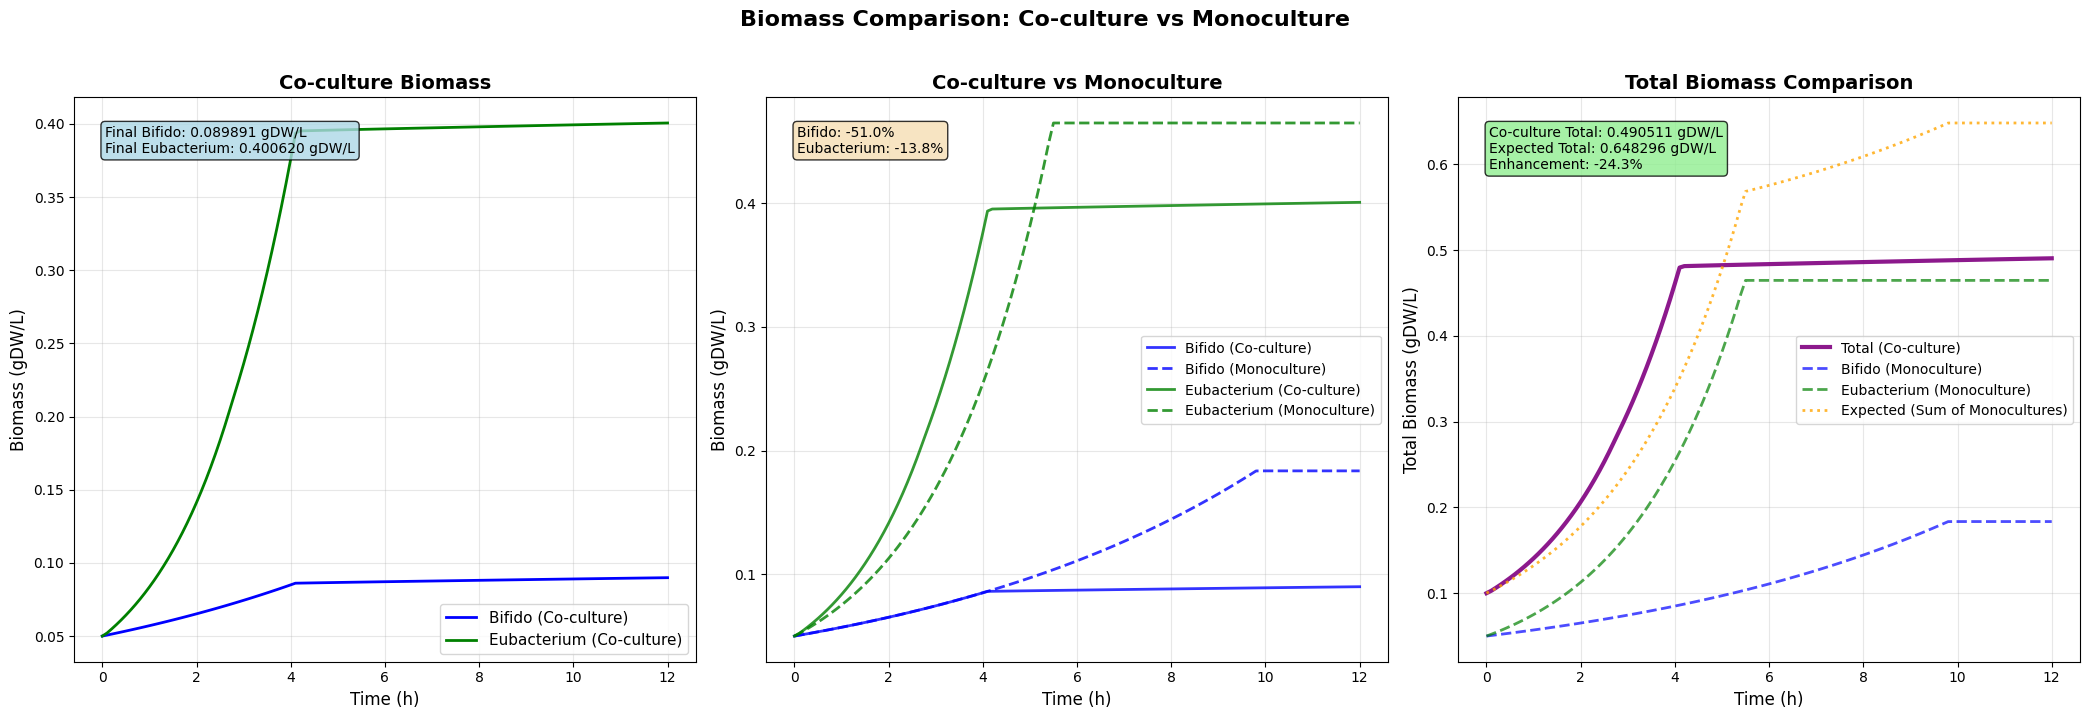


 Biomass Summary

co-culture:
  Bifido: 0.089891 gDW/L
  Eubacterium: 0.400620 gDW/L
  Total: 0.490511 gDW/L

Monoculture:
  Bifido: 0.183536 gDW/L
  Eubacterium: 0.464760 gDW/L
  Expected Total (sum): 0.648296 gDW/L

Enhancement in Co-culture:
  Bifido: -51.0%
  Eubacterium: -13.8%
  Total Biomass: -24.3%


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Biomass Comparison: Co-culture vs Monoculture', 
             fontsize=16, fontweight='bold', y=1.02)

# Subplot 1: Co-culture biomass (both species)
ax = axes[0]
ax.plot(time_co, biomass_co_bifido, 'b-', linewidth=2, label='Bifido (Co-culture)')
ax.plot(time_co, biomass_co_eubact, 'g-', linewidth=2, label='Eubacterium (Co-culture)')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (gDW/L)', fontsize=12)
ax.set_title('Co-culture Biomass', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Add final values
final_co_bifido = biomass_co_bifido[-1]
final_co_eubact = biomass_co_eubact[-1]
ax.text(0.05, 0.95, 
        f'Final Bifido: {final_co_bifido:.6f} gDW/L\n'
        f'Final Eubacterium: {final_co_eubact:.6f} gDW/L',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Subplot 2: Co-culture vs Monoculture comparison
ax = axes[1]
# Bifido comparison
ax.plot(time_co, biomass_co_bifido, 'b-', linewidth=2, label='Bifido (Co-culture)', alpha=0.8)
ax.plot(time_mono_bifido, biomass_mono_bifido, 'b--', linewidth=2, label='Bifido (Monoculture)', alpha=0.8)

# Eubacterium comparison
ax.plot(time_co, biomass_co_eubact, 'g-', linewidth=2, label='Eubacterium (Co-culture)', alpha=0.8)
ax.plot(time_mono_eubact, biomass_mono_eubact, 'g--', linewidth=2, label='Eubacterium (Monoculture)', alpha=0.8)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (gDW/L)', fontsize=12)
ax.set_title('Co-culture vs Monoculture', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)

# Add comparison values
final_mono_bifido = biomass_mono_bifido[-1]
final_mono_eubact = biomass_mono_eubact[-1]

bifido_enhancement = ((final_co_bifido - final_mono_bifido) / final_mono_bifido * 100) if final_mono_bifido > 0 else 0
eubact_enhancement = ((final_co_eubact - final_mono_eubact) / final_mono_eubact * 100) if final_mono_eubact > 0 else 0

ax.text(0.05, 0.95, 
        f'Bifido: {bifido_enhancement:+.1f}%\n'
        f'Eubacterium: {eubact_enhancement:+.1f}%',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))


# Subplot 3: Total biomass comparison
# Calculate total biomass
total_biomass_co = biomass_co_bifido + biomass_co_eubact
total_biomass_mono_bifido = biomass_mono_bifido
total_biomass_mono_eubact = biomass_mono_eubact
total_biomass_mono_combined = total_biomass_mono_bifido + total_biomass_mono_eubact

ax = axes[2]
ax.plot(time_co, total_biomass_co, 'purple', linewidth=3, label='Total (Co-culture)', alpha=0.9)
ax.plot(time_mono_bifido, total_biomass_mono_bifido, 'b--', linewidth=2, label='Bifido (Monoculture)', alpha=0.7)
ax.plot(time_mono_eubact, total_biomass_mono_eubact, 'g--', linewidth=2, label='Eubacterium (Monoculture)', alpha=0.7)

# Calculate expected total 
min_len = min(len(time_co), len(time_mono_bifido), len(time_mono_eubact))
time_aligned = time_co[:min_len]
total_co_aligned = total_biomass_co[:min_len]
total_mono_bifido_aligned = total_biomass_mono_bifido[:min_len]
total_mono_eubact_aligned = total_biomass_mono_eubact[:min_len]
expected_total = total_mono_bifido_aligned + total_mono_eubact_aligned

ax.plot(time_aligned, expected_total, 'orange', linewidth=2, linestyle=':', 
        label='Expected (Sum of Monocultures)', alpha=0.8)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Total Biomass (gDW/L)', fontsize=12)
ax.set_title('Total Biomass Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)

# Add total biomass values
final_total_co = total_biomass_co[-1]
final_expected_total = total_biomass_mono_bifido[-1] + total_biomass_mono_eubact[-1]
total_enhancement = ((final_total_co - final_expected_total) / final_expected_total * 100) if final_expected_total > 0 else 0

ax.text(0.05, 0.95, 
        f'Co-culture Total: {final_total_co:.6f} gDW/L\n'
        f'Expected Total: {final_expected_total:.6f} gDW/L\n'
        f'Enhancement: {total_enhancement:+.1f}%',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary
print("\n Biomass Summary\n")
print(f"co-culture:")
print(f"  Bifido: {final_co_bifido:.6f} gDW/L")
print(f"  Eubacterium: {final_co_eubact:.6f} gDW/L")
print(f"  Total: {final_total_co:.6f} gDW/L")
print(f"\nMonoculture:")
print(f"  Bifido: {final_mono_bifido:.6f} gDW/L")
print(f"  Eubacterium: {final_mono_eubact:.6f} gDW/L")
print(f"  Expected Total (sum): {final_expected_total:.6f} gDW/L")
print(f"\nEnhancement in Co-culture:")
print(f"  Bifido: {bifido_enhancement:+.1f}%")
print(f"  Eubacterium: {eubact_enhancement:+.1f}%")
print(f"  Total Biomass: {total_enhancement:+.1f}%")


Found Eubacterium butyrate flux (monoculture)
Found Eubacterium butyrate flux (co-culture)


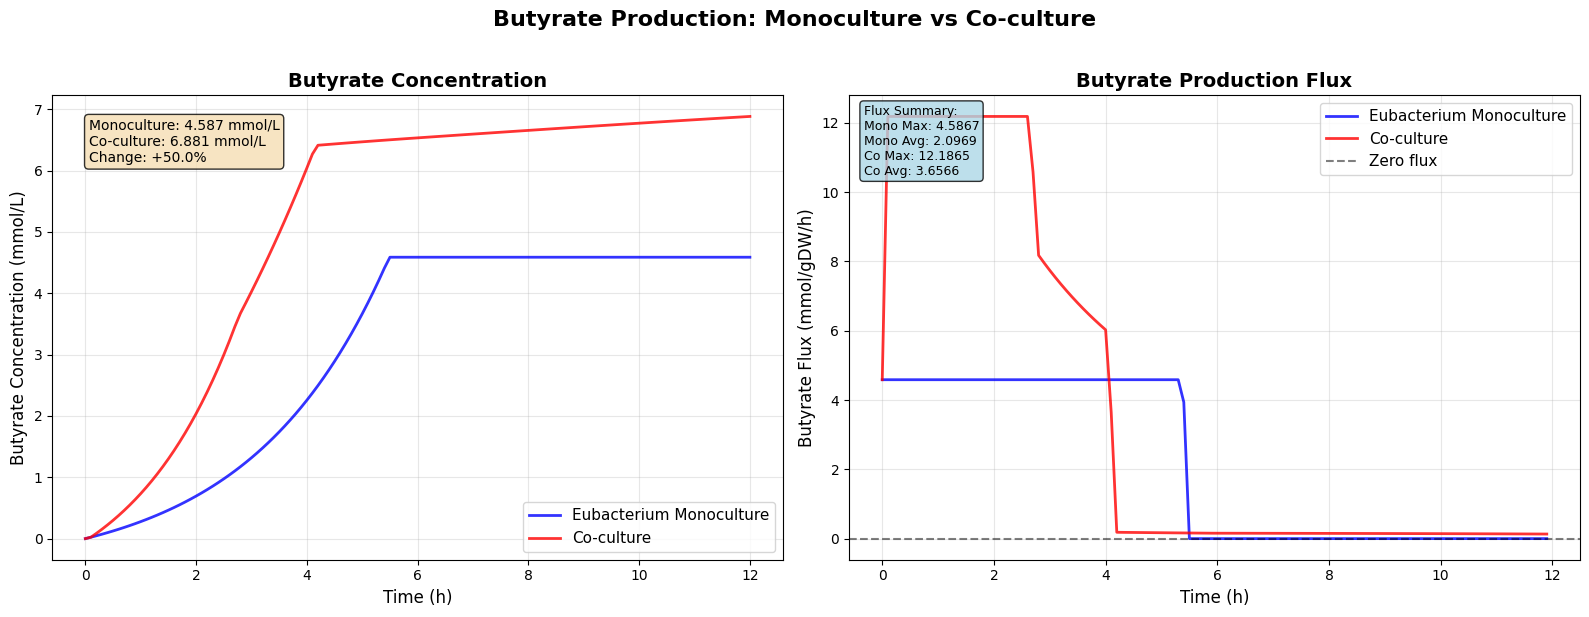

In [ ]:
# Extract metabolite concentration data
def get_met_data(sim, metabolite):
    media = sim.get_metabolite_time_series()
    if metabolite in media.columns:
        return media[metabolite].values
    else:
        return np.zeros(len(media))

# Get time arrays
time_mono_eubact = np.arange(len(sim_mono_Eubacterium.total_biomass)) * t_step
time_co = np.arange(len(sim_co.total_biomass)) * t_step

# Extract butyrate concentrations 
but_mono_eubact = get_met_data(sim_mono_Eubacterium, 'but[e]')
but_co = get_met_data(sim_co, 'but[e]')

# Extract butyrate fluxes
flux_mono_eubact = sim_mono_Eubacterium.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)
flux_eubact_co = sim_co.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)

# Get time arrays for fluxes
time_flux_mono_eubact = np.arange(len(flux_mono_eubact)) * t_step
time_flux_eubact_co = np.arange(len(flux_eubact_co)) * t_step

# Extract butyrate flux
but_flux_col = 'EX_but(e)'

but_flux_mono_eubact = None
but_flux_eubact_co = None

if but_flux_col in flux_mono_eubact.columns:
    but_flux_mono_eubact = flux_mono_eubact[but_flux_col].values
    print(f"Found Eubacterium butyrate flux (monoculture)")

if but_flux_col in flux_eubact_co.columns:
    but_flux_eubact_co = flux_eubact_co[but_flux_col].values
    print(f"Found Eubacterium butyrate flux (co-culture)")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Butyrate Production: Monoculture vs Co-culture', 
             fontsize=16, fontweight='bold', y=1.02)

# Subplot 1: Butyrate concentration
ax = axes[0]
ax.plot(time_mono_eubact, but_mono_eubact, 'b-', linewidth=2, label='Eubacterium Monoculture', alpha=0.8)
ax.plot(time_co, but_co, 'r-', linewidth=2, label='Co-culture', alpha=0.8)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Concentration (mmol/L)', fontsize=12)
ax.set_title('Butyrate Concentration', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Add final values
final_but_mono = but_mono_eubact[-1]
final_but_co = but_co[-1]

if final_but_mono > 0:
    but_enhancement = ((final_but_co - final_but_mono) / final_but_mono) * 100
    ax.text(0.05, 0.95, 
            f'Monoculture: {final_but_mono:.3f} mmol/L\n'
            f'Co-culture: {final_but_co:.3f} mmol/L\n'
            f'Change: {but_enhancement:+.1f}%',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
else:
    ax.text(0.05, 0.95, 
            f'Monoculture: {final_but_mono:.3f} mmol/L\n'
            f'Co-culture: {final_but_co:.3f} mmol/L',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 2: Butyrate flux
ax = axes[1]

# Plot butyrate production flux 
if but_flux_mono_eubact is not None:
    time_mono_flux = time_flux_mono_eubact[:len(but_flux_mono_eubact)]
    ax.plot(time_mono_flux, but_flux_mono_eubact, 'b-', linewidth=2, 
            label='Eubacterium Monoculture', alpha=0.8)

if but_flux_eubact_co is not None:
    time_co_flux = time_flux_eubact_co[:len(but_flux_eubact_co)]
    ax.plot(time_co_flux, but_flux_eubact_co, 'r-', linewidth=2, 
            label='Co-culture', alpha=0.8)

# Add zero reference line
ax.axhline(y=0, color='k', linestyle='--', linewidth=1.5, alpha=0.5, label='Zero flux')

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Butyrate Production Flux', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)

# Add flux summary
if but_flux_mono_eubact is not None and but_flux_eubact_co is not None:
    flux_text = f"""Flux Summary:
Mono Max: {but_flux_mono_eubact.max():.4f}
Mono Avg: {but_flux_mono_eubact.mean():.4f}
Co Max: {but_flux_eubact_co.max():.4f}
Co Avg: {but_flux_eubact_co.mean():.4f}"""
    ax.text(0.02, 0.98, flux_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

Found Bifido lactate flux
Found Eubacterium lactate flux


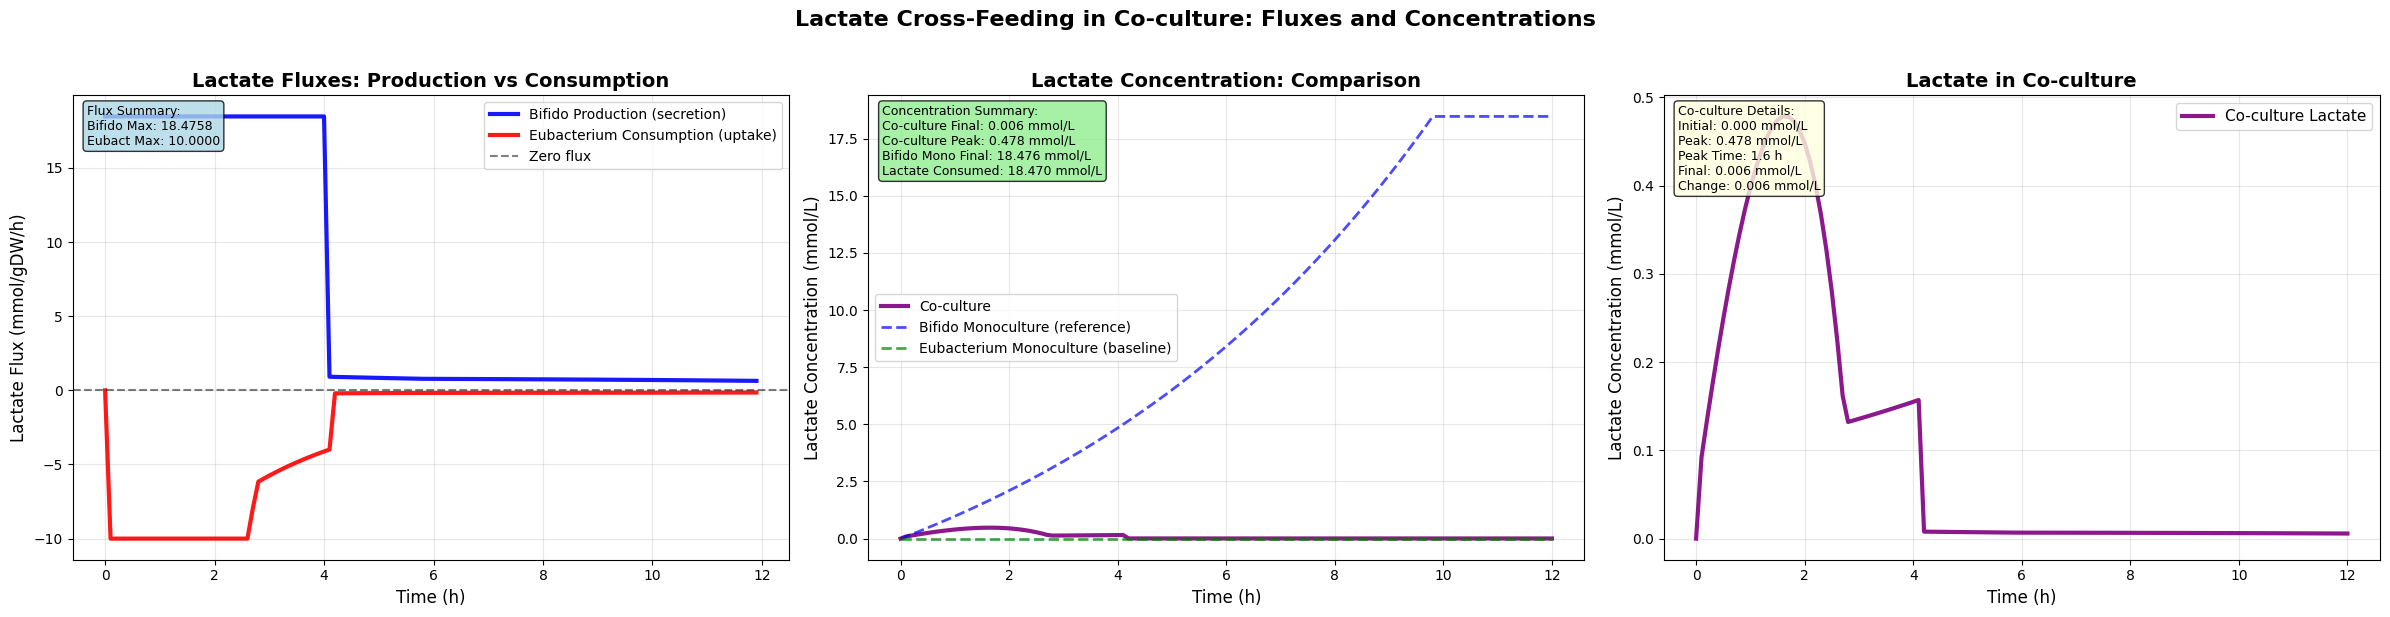

In [8]:
# Extract lactate flux data for both species in co-culture
flux_bifido_co = sim_co.get_species_exchange_fluxes('Bifido', threshold=1e-8)
flux_eubact_co = sim_co.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)

# Get time arrays for fluxes
time_flux_bifido = np.arange(len(flux_bifido_co)) * t_step
time_flux_eubact = np.arange(len(flux_eubact_co)) * t_step

# Extract lactate fluxes
lac_flux_col = 'EX_lac_L(e)'

bifido_lac_flux = None
eubact_lac_flux = None

if lac_flux_col in flux_bifido_co.columns:
    bifido_lac_flux = flux_bifido_co[lac_flux_col].values
    print(f"Found Bifido lactate flux")

if lac_flux_col in flux_eubact_co.columns:
    eubact_lac_flux = flux_eubact_co[lac_flux_col].values
    print(f"Found Eubacterium lactate flux")

# Extract lactate concentrations
media_co = sim_co.get_metabolite_time_series()
media_mono_bifido = sim_mono_Bifido.get_metabolite_time_series()
media_mono_eubact = sim_mono_Eubacterium.get_metabolite_time_series()

time_co = np.arange(len(media_co)) * t_step
time_mono_bifido = np.arange(len(media_mono_bifido)) * t_step
time_mono_eubact = np.arange(len(media_mono_eubact)) * t_step

lac_co = media_co['lac_L[e]'].values if 'lac_L[e]' in media_co.columns else np.zeros(len(media_co))
lac_mono_bifido = media_mono_bifido['lac_L[e]'].values if 'lac_L[e]' in media_mono_bifido.columns else np.zeros(len(media_mono_bifido))
lac_mono_eubact = media_mono_eubact['lac_L[e]'].values if 'lac_L[e]' in media_mono_eubact.columns else np.zeros(len(media_mono_eubact))

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
fig.suptitle('Lactate Cross-Feeding in Co-culture: Fluxes and Concentrations', 
             fontsize=16, fontweight='bold', y=1.02)

# Subplot 1: Fluxes
ax = axes[0]

# Plot Bifido lactate production (positive flux)
if bifido_lac_flux is not None:
    time_bifido = time_flux_bifido[:len(bifido_lac_flux)]
    ax.plot(time_bifido, bifido_lac_flux, 'b-', linewidth=3, 
            label='Bifido Production (secretion)', alpha=0.9)
    max_production = bifido_lac_flux.max()

# Plot Eubacterium lactate consumption (negative flux)
if eubact_lac_flux is not None:
    time_eubact = time_flux_eubact[:len(eubact_lac_flux)]
    ax.plot(time_eubact, eubact_lac_flux, 'r-', linewidth=3, 
            label='Eubacterium Consumption (uptake)', alpha=0.9)
    min_consumption = eubact_lac_flux.min()

# Add zero reference line
ax.axhline(y=0, color='k', linestyle='--', linewidth=1.5, alpha=0.5, label='Zero flux')

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Lactate Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Lactate Fluxes: Production vs Consumption', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)

# Add flux summary
if bifido_lac_flux is not None and eubact_lac_flux is not None:
    flux_text = f"""Flux Summary:
Bifido Max: {bifido_lac_flux.max():.4f}
Eubact Max: {abs(eubact_lac_flux.min()):.4f}"""
    ax.text(0.02, 0.98, flux_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Subplot 2: Concentrations with references
ax = axes[1]

# Plot lactate concentration in co-culture
ax.plot(time_co, lac_co, 'purple', linewidth=3, label='Co-culture', alpha=0.9)

# Plot reference: Bifido monoculture (shows production)
ax.plot(time_mono_bifido, lac_mono_bifido, 'b--', linewidth=2, 
        label='Bifido Monoculture (reference)', alpha=0.7)

# Plot reference: Eubacterium monoculture (baseline)
ax.plot(time_mono_eubact, lac_mono_eubact, 'g--', linewidth=2, 
        label='Eubacterium Monoculture (baseline)', alpha=0.7)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Lactate Concentration (mmol/L)', fontsize=12)
ax.set_title('Lactate Concentration: Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)

# Add concentration summary
final_lac_co = lac_co[-1]
final_lac_mono_bifido = lac_mono_bifido[-1]
final_lac_mono_eubact = lac_mono_eubact[-1]
max_lac_co = lac_co.max()

# Calculate lactate consumed
lac_consumed = final_lac_mono_bifido - final_lac_co if final_lac_mono_bifido > final_lac_co else 0

conc_text = f"""Concentration Summary:
Co-culture Final: {final_lac_co:.3f} mmol/L
Co-culture Peak: {max_lac_co:.3f} mmol/L
Bifido Mono Final: {final_lac_mono_bifido:.3f} mmol/L
Lactate Consumed: {lac_consumed:.3f} mmol/L"""
ax.text(0.02, 0.98, conc_text, transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Subplot 3: Co-culture concentration only
ax = axes[2]

# Plot only co-culture lactate concentration
ax.plot(time_co, lac_co, 'purple', linewidth=3, label='Co-culture Lactate', alpha=0.9)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Lactate Concentration (mmol/L)', fontsize=12)
ax.set_title('Lactate in Co-culture', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Add co-culture summary
co_conc_text = f"""Co-culture Details:
Initial: {lac_co[0]:.3f} mmol/L
Peak: {max_lac_co:.3f} mmol/L
Peak Time: {time_co[np.argmax(lac_co)]:.1f} h
Final: {final_lac_co:.3f} mmol/L
Change: {final_lac_co - lac_co[0]:.3f} mmol/L"""
ax.text(0.02, 0.98, co_conc_text, transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

Found Bifido acetate flux
Found Eubacterium acetate flux


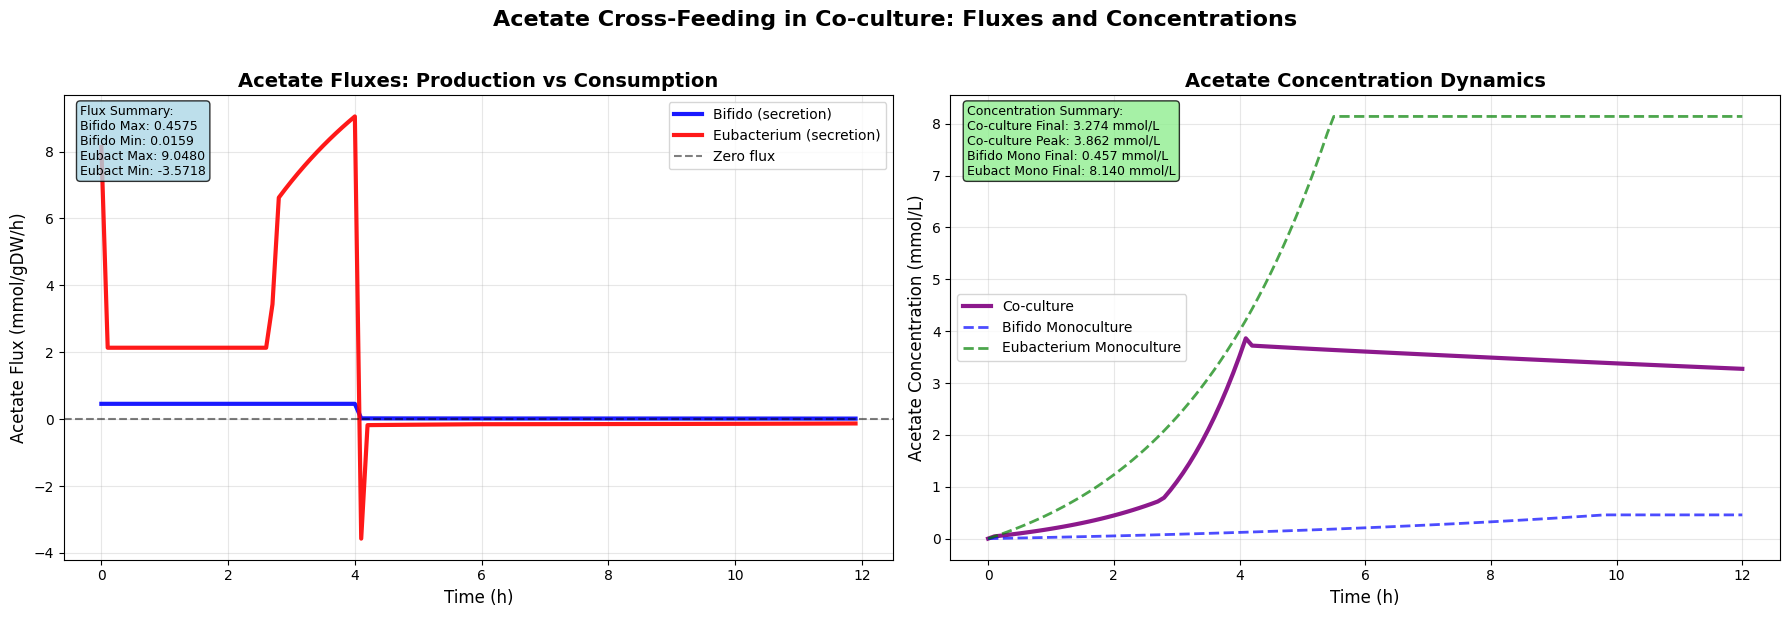

In [ ]:
# Extract acetate flux data for both species in co-culture
flux_bifido_co = sim_co.get_species_exchange_fluxes('Bifido', threshold=1e-8)
flux_eubact_co = sim_co.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)

# Get time arrays for fluxes
time_flux_bifido = np.arange(len(flux_bifido_co)) * t_step
time_flux_eubact = np.arange(len(flux_eubact_co)) * t_step

# Extract acetate fluxes
ac_flux_col = 'EX_ac(e)'

bifido_ac_flux = None
eubact_ac_flux = None

if ac_flux_col in flux_bifido_co.columns:
    bifido_ac_flux = flux_bifido_co[ac_flux_col].values
    print(f"Found Bifido acetate flux")

if ac_flux_col in flux_eubact_co.columns:
    eubact_ac_flux = flux_eubact_co[ac_flux_col].values
    print(f"Found Eubacterium acetate flux")

# Extract acetate concentrations
media_co = sim_co.get_metabolite_time_series()
media_mono_bifido = sim_mono_Bifido.get_metabolite_time_series()
media_mono_eubact = sim_mono_Eubacterium.get_metabolite_time_series()

time_co = np.arange(len(media_co)) * t_step
time_mono_bifido = np.arange(len(media_mono_bifido)) * t_step
time_mono_eubact = np.arange(len(media_mono_eubact)) * t_step

ac_co = media_co['ac[e]'].values if 'ac[e]' in media_co.columns else np.zeros(len(media_co))
ac_mono_bifido = media_mono_bifido['ac[e]'].values if 'ac[e]' in media_mono_bifido.columns else np.zeros(len(media_mono_bifido))
ac_mono_eubact = media_mono_eubact['ac[e]'].values if 'ac[e]' in media_mono_eubact.columns else np.zeros(len(media_mono_eubact))

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Acetate Cross-Feeding in Co-culture: Fluxes and Concentrations', 
             fontsize=16, fontweight='bold', y=1.02)

# Subplot 1: Fluxes
ax = axes[0]

# Plot Bifido acetate flux 
if bifido_ac_flux is not None:
    time_bifido = time_flux_bifido[:len(bifido_ac_flux)]
    if bifido_ac_flux.max() > 1e-6:
        ax.plot(time_bifido, bifido_ac_flux, 'b-', linewidth=3, 
                label='Bifido (secretion)', alpha=0.9)
    elif bifido_ac_flux.min() < -1e-6:
        ax.plot(time_bifido, bifido_ac_flux, 'b--', linewidth=3, 
                label='Bifido (uptake)', alpha=0.9)
    else:
        ax.plot(time_bifido, bifido_ac_flux, 'b-', linewidth=2, 
                label='Bifido', alpha=0.7)
    max_production = bifido_ac_flux.max()

# Plot Eubacterium acetate flux 
if eubact_ac_flux is not None:
    time_eubact = time_flux_eubact[:len(eubact_ac_flux)]
    if eubact_ac_flux.max() > 1e-6:
        ax.plot(time_eubact, eubact_ac_flux, 'r-', linewidth=3, 
                label='Eubacterium (secretion)', alpha=0.9)
    elif eubact_ac_flux.min() < -1e-6:
        ax.plot(time_eubact, eubact_ac_flux, 'r--', linewidth=3, 
                label='Eubacterium (uptake)', alpha=0.9)
    else:
        ax.plot(time_eubact, eubact_ac_flux, 'r-', linewidth=2, 
                label='Eubacterium', alpha=0.7)
    min_consumption = eubact_ac_flux.min()

# Add zero reference line
ax.axhline(y=0, color='k', linestyle='--', linewidth=1.5, alpha=0.5, label='Zero flux')

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Acetate Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Acetate Fluxes: Production vs Consumption', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)

# Add flux summary
if bifido_ac_flux is not None and eubact_ac_flux is not None:
    flux_text = f"""Flux Summary:
Bifido Max: {bifido_ac_flux.max():.4f}
Bifido Min: {bifido_ac_flux.min():.4f}
Eubact Max: {eubact_ac_flux.max():.4f}
Eubact Min: {eubact_ac_flux.min():.4f}"""
    ax.text(0.02, 0.98, flux_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Subplot 2: Concentrations
ax = axes[1]

# Plot acetate concentration in co-culture
ax.plot(time_co, ac_co, 'purple', linewidth=3, label='Co-culture', alpha=0.9)

# Plot reference: Bifido monoculture
ax.plot(time_mono_bifido, ac_mono_bifido, 'b--', linewidth=2, 
        label='Bifido Monoculture', alpha=0.7)

# Plot reference: Eubacterium monoculture
ax.plot(time_mono_eubact, ac_mono_eubact, 'g--', linewidth=2, 
        label='Eubacterium Monoculture', alpha=0.7)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Acetate Concentration (mmol/L)', fontsize=12)
ax.set_title('Acetate Concentration Dynamics', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)

# Add concentration summary
final_ac_co = ac_co[-1]
final_ac_mono_bifido = ac_mono_bifido[-1]
final_ac_mono_eubact = ac_mono_eubact[-1]
max_ac_co = ac_co.max()

conc_text = f"""Concentration Summary:
Co-culture Final: {final_ac_co:.3f} mmol/L
Co-culture Peak: {max_ac_co:.3f} mmol/L
Bifido Mono Final: {final_ac_mono_bifido:.3f} mmol/L
Eubact Mono Final: {final_ac_mono_eubact:.3f} mmol/L"""
ax.text(0.02, 0.98, conc_text, transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

Found 35 metabolites with significant changes
Metabolites: ['4abut[e]', 'ac[e]', 'ala_L[e]', 'asn_L[e]', 'but[e]', 'ca2[e]', 'cd2[e]', 'cl[e]', 'co2[e]', 'cobalt2[e]', 'cu2[e]', 'fe2[e]', 'fe3[e]', 'glc_D[e]', 'glycys[e]', 'glyglu[e]', 'h2[e]', 'h2o[e]', 'h[e]', 'his_L[e]']...


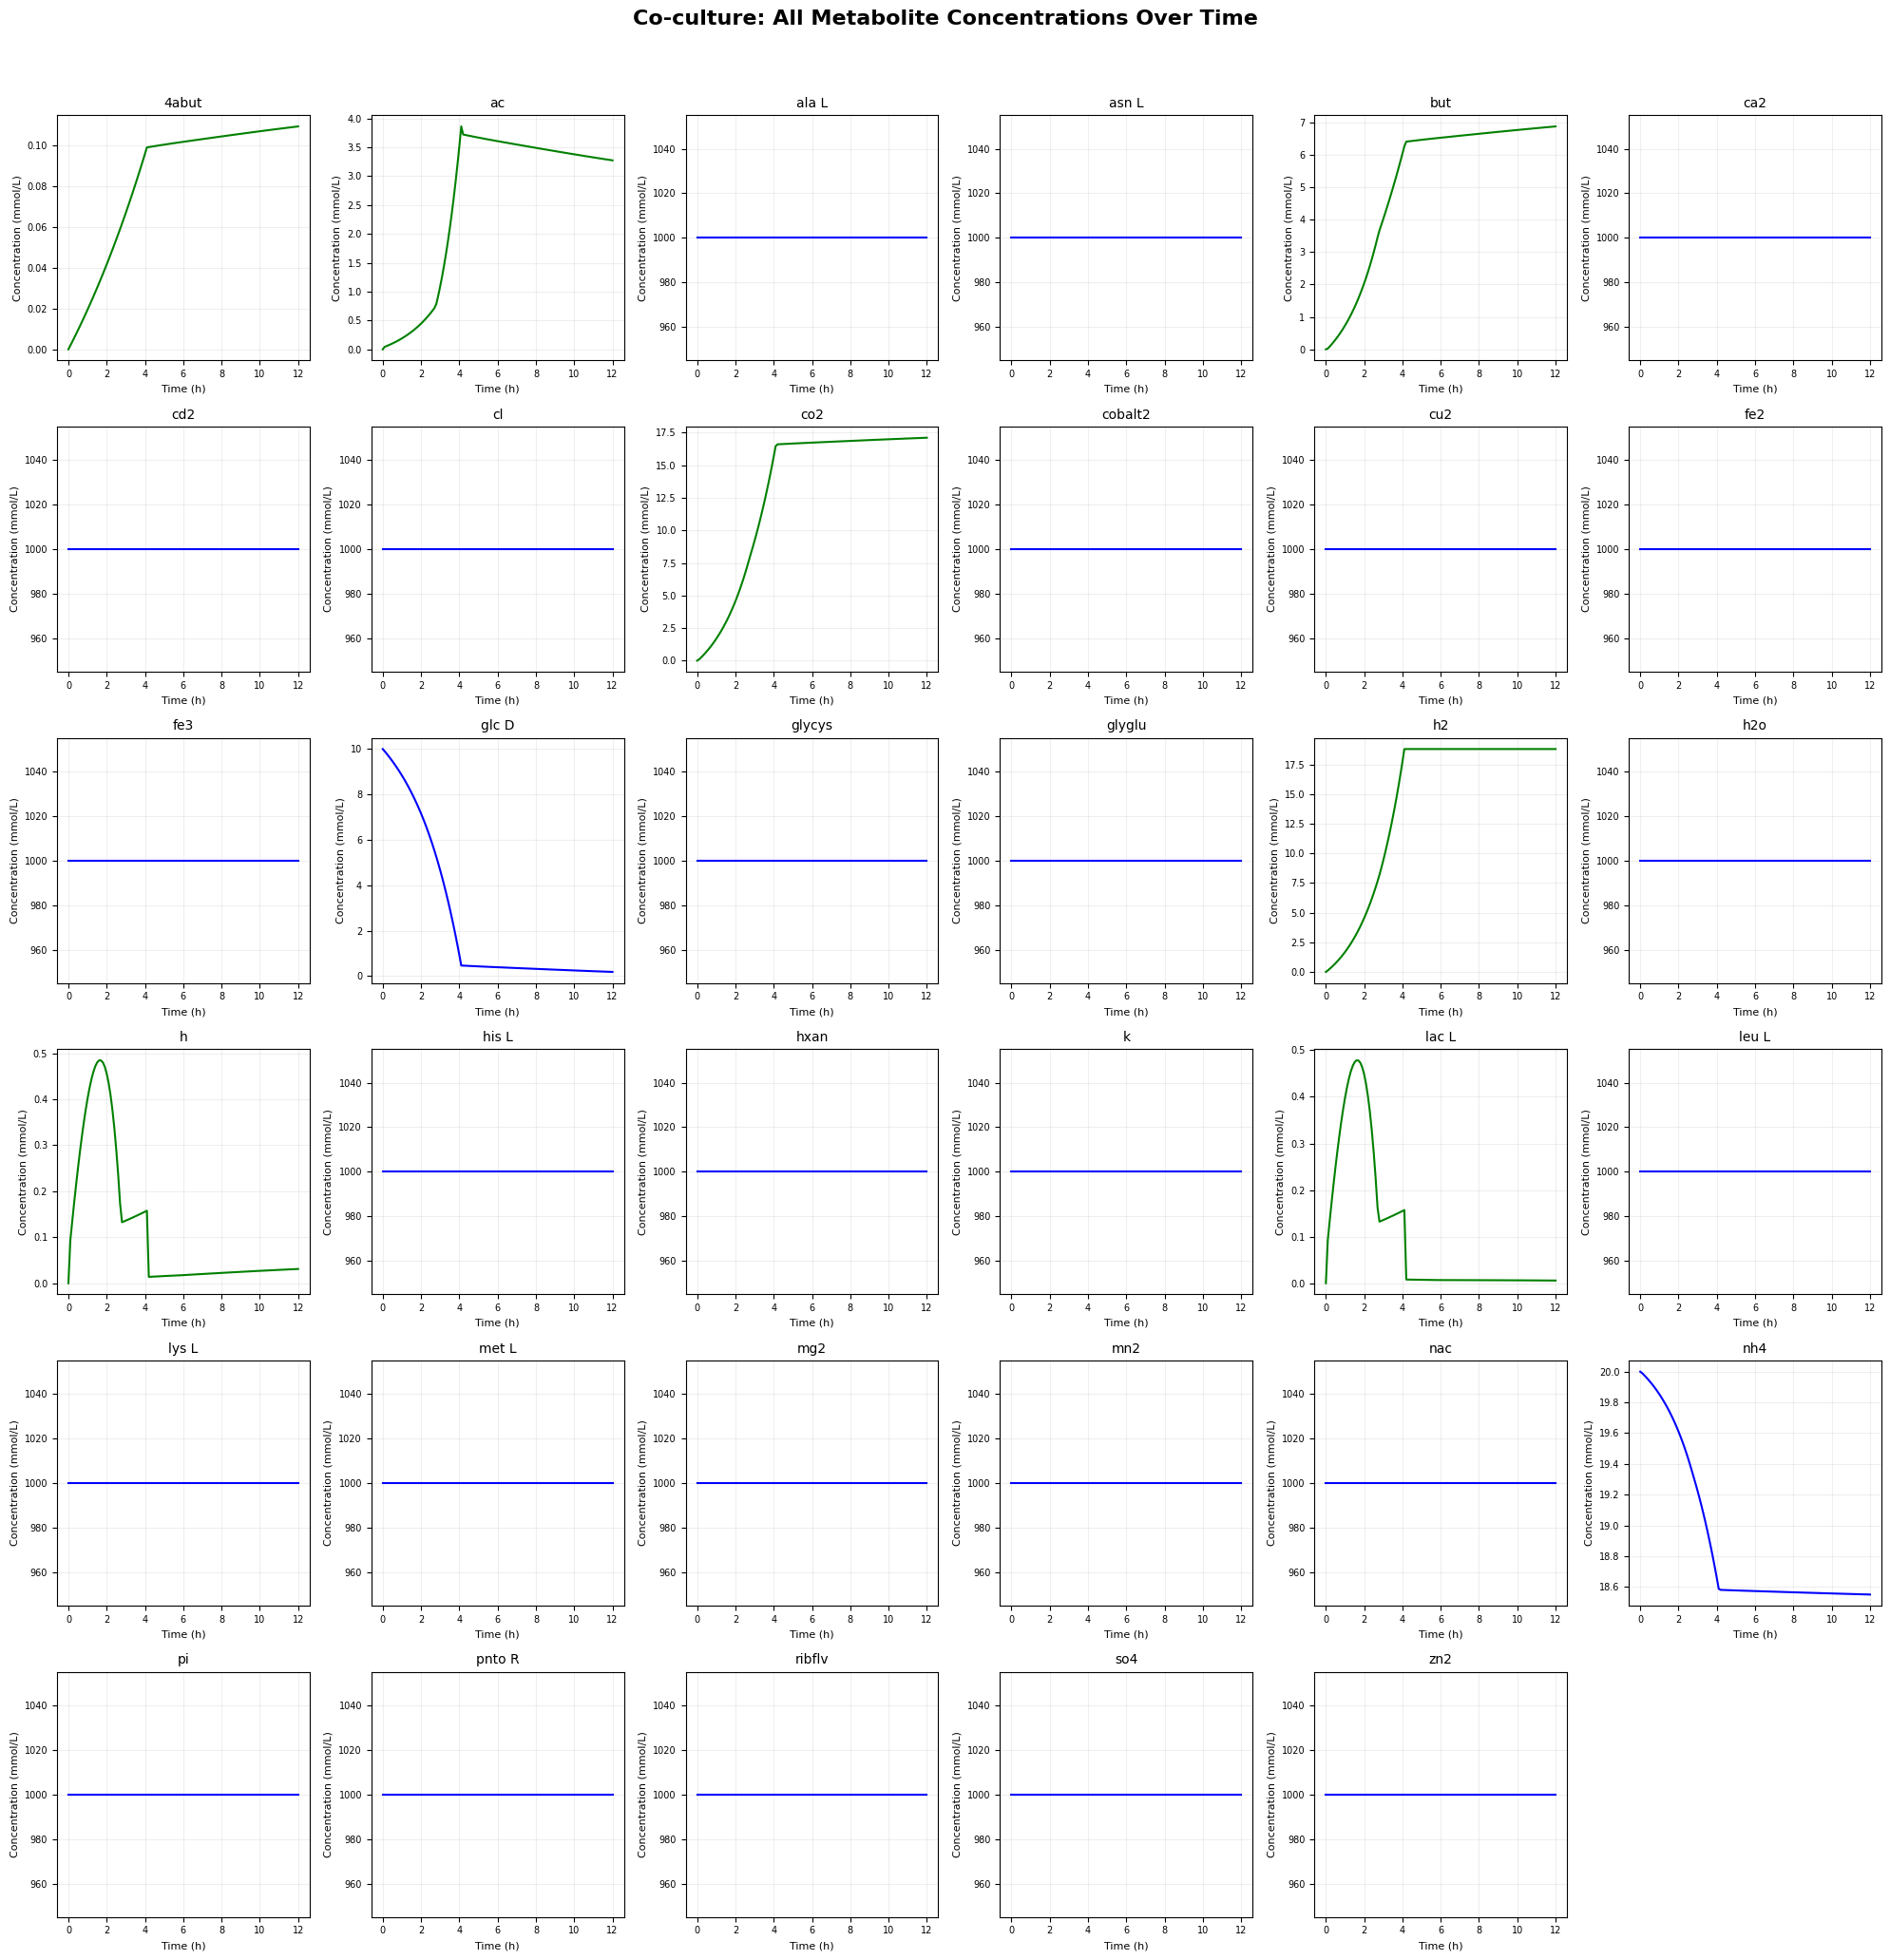

In [10]:
media_co = sim_co.get_metabolite_time_series()
time_co = np.arange(len(media_co)) * t_step

# Get all metabolites
all_metabolites = sorted([col for col in media_co.columns 
                          if col != 'cycle' and 'biomass' not in col.lower()])

# Filter to only metabolites with significant changes 
significant_mets = []
for met in all_metabolites:
    conc = media_co[met].values  
    if len(conc) > 0:
        # array indexing
        if conc.max() - conc.min() > 0.01 or conc[0] > 0.01 or conc[-1] > 0.01:
            significant_mets.append(met)

print(f"Found {len(significant_mets)} metabolites with significant changes")
print(f"Metabolites: {significant_mets[:20]}...")  # Show first 20

# subplots for significant metabolites
num_mets = len(significant_mets)
cols = 6
rows = math.ceil(num_mets / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5 * rows))
fig.suptitle('Co-culture: All Metabolite Concentrations Over Time', 
             fontsize=16, fontweight='bold', y=0.98)

# Flatten axes if needed
if rows == 1:
    axes = axes.reshape(1, -1)
elif cols == 1:
    axes = axes.reshape(-1, 1)

time_co = np.arange(len(media_co)) * t_step

for i, met in enumerate(significant_mets):
    row = i // cols
    col = i % cols
    
    if row < axes.shape[0] and col < axes.shape[1]:
        ax = axes[row, col]
        
        conc = media_co[met].values
        
        # Color coding - use array indexing
        if len(conc) > 0:
            if conc[0] > 0.01 and conc[-1] < 0.01:
                line_color = 'red'
            elif conc[0] < 0.01 and conc.max() > 0.01:
                line_color = 'green'
            else:
                line_color = 'blue'
        else:
            line_color = 'blue'
        
        ax.plot(time_co, conc, color=line_color, linewidth=1.5)
        ax.set_xlabel('Time (h)', fontsize=8)
        ax.set_ylabel('Concentration (mmol/L)', fontsize=8)
        
        met_name = met.replace('[e]', '').replace('_', ' ')
        ax.set_title(met_name, fontsize=10)
        ax.grid(alpha=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)

# Remove empty subplots
for i in range(len(significant_mets), rows * cols):
    row = i // cols
    col = i % cols
    if row < axes.shape[0] and col < axes.shape[1]:
        fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Bifido: 29 significant exchange fluxes


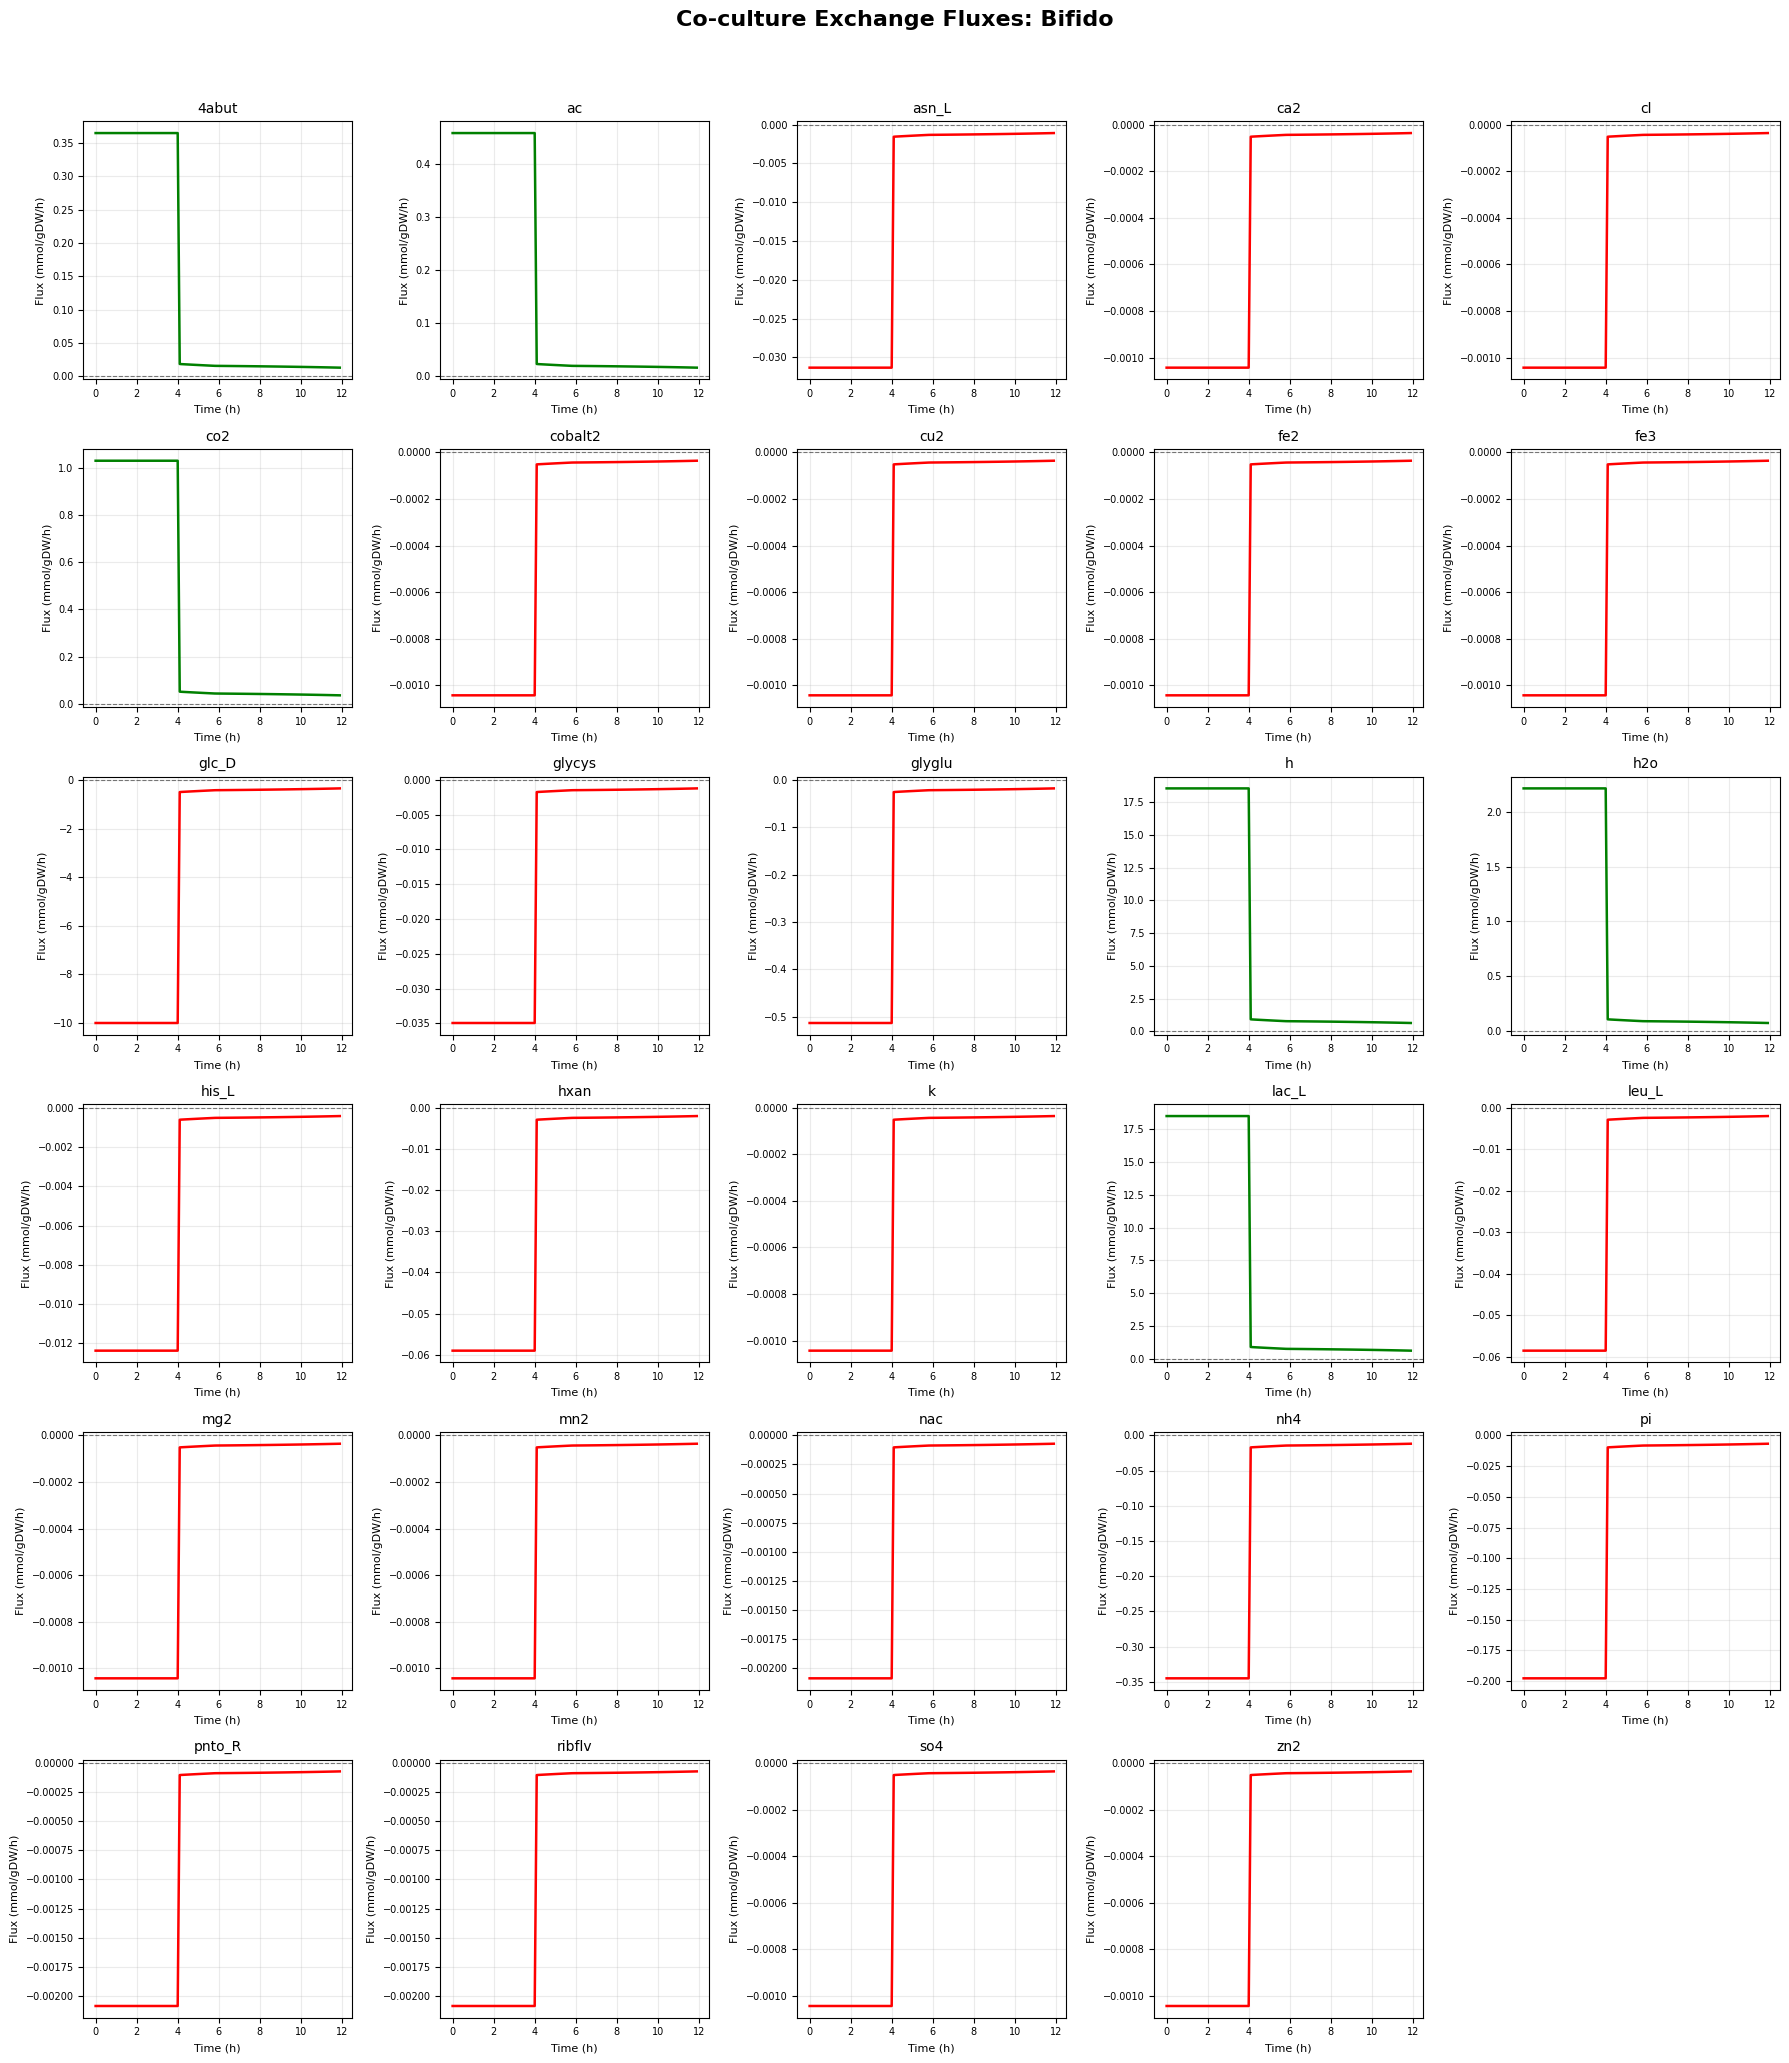

Eubacterium: 32 significant exchange fluxes


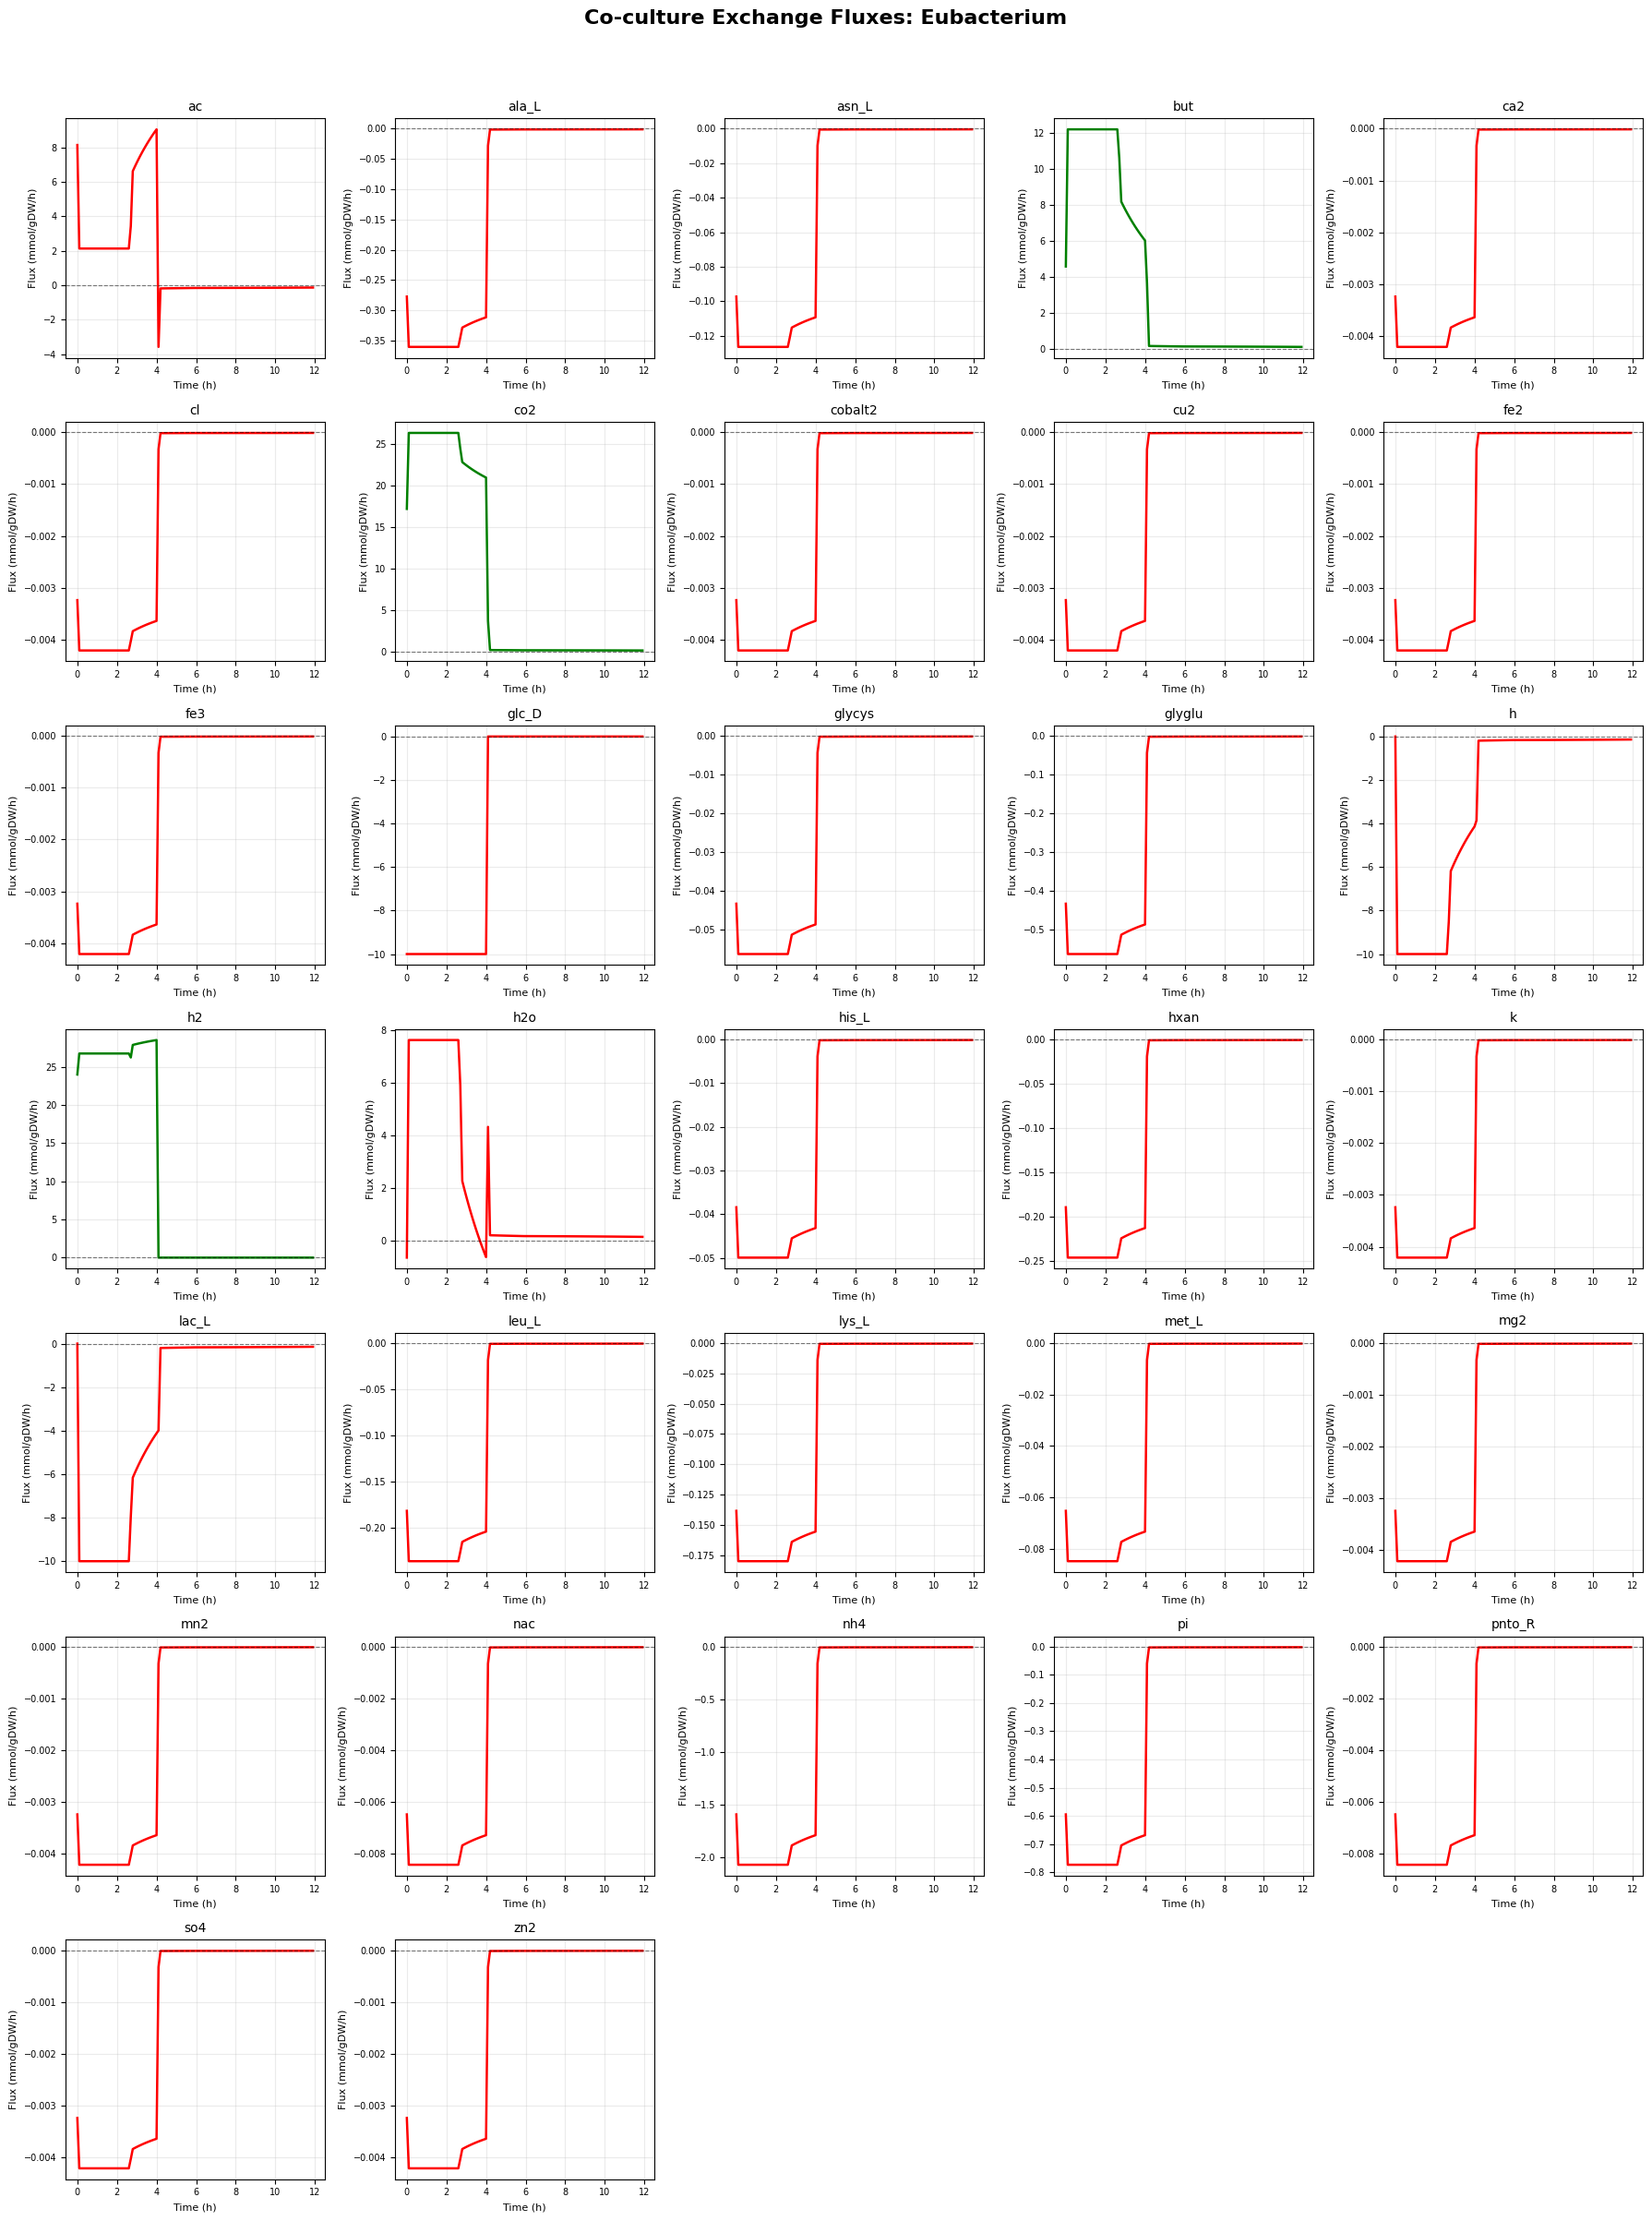

In [ ]:

species_list = ['Bifido', 'Eubacterium']

#time array for fluxes
time_flux = np.arange(len(sim_co.fluxes)) * params.all_params['timeStep']

# Threshold
flux_thresh = 1e-6

for sp in species_list:
    flux_df = sim_co.get_species_exchange_fluxes(sp, threshold=flux_thresh)

    # Exchange flux columns
    ex_cols = [c for c in flux_df.columns if c.startswith('EX_') and 'biomass' not in c.lower()]
    
    # Keep only columns with any flux above threshold
    sig_cols = [c for c in ex_cols if np.abs(flux_df[c].values).max() > flux_thresh]
    sig_cols = sorted(sig_cols)
    
    print(f"{sp}: {len(sig_cols)} significant exchange fluxes")
    
    if not sig_cols:
        continue
    
    cols = 5
    rows = math.ceil(len(sig_cols) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(18, 3.5 * rows))
    fig.suptitle(f'Co-culture Exchange Fluxes: {sp}', fontsize=16, fontweight='bold', y=0.98)
    
    # Flatten axes for easy indexing
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, col in enumerate(sig_cols):
        ax = axes[i]
        vals = flux_df[col].values
        
        # Color: red = uptake (negative), green = secretion (positive), gray = near zero
        if vals.min() < -flux_thresh:
            color = 'red'
        elif vals.max() > flux_thresh:
            color = 'green'
        else:
            color = 'gray'
        
        ax.plot(time_flux[:len(vals)], vals, color=color, linewidth=1.8)
        ax.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
        met_name = col.replace('EX_', '').replace('(e)', '')
        ax.set_title(met_name, fontsize=10)
        ax.set_xlabel('Time (h)', fontsize=8)
        ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=8)
        ax.grid(alpha=0.25)
        ax.tick_params(axis='both', which='major', labelsize=7)
    
    # Remove any unused subplots
    for j in range(len(sig_cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

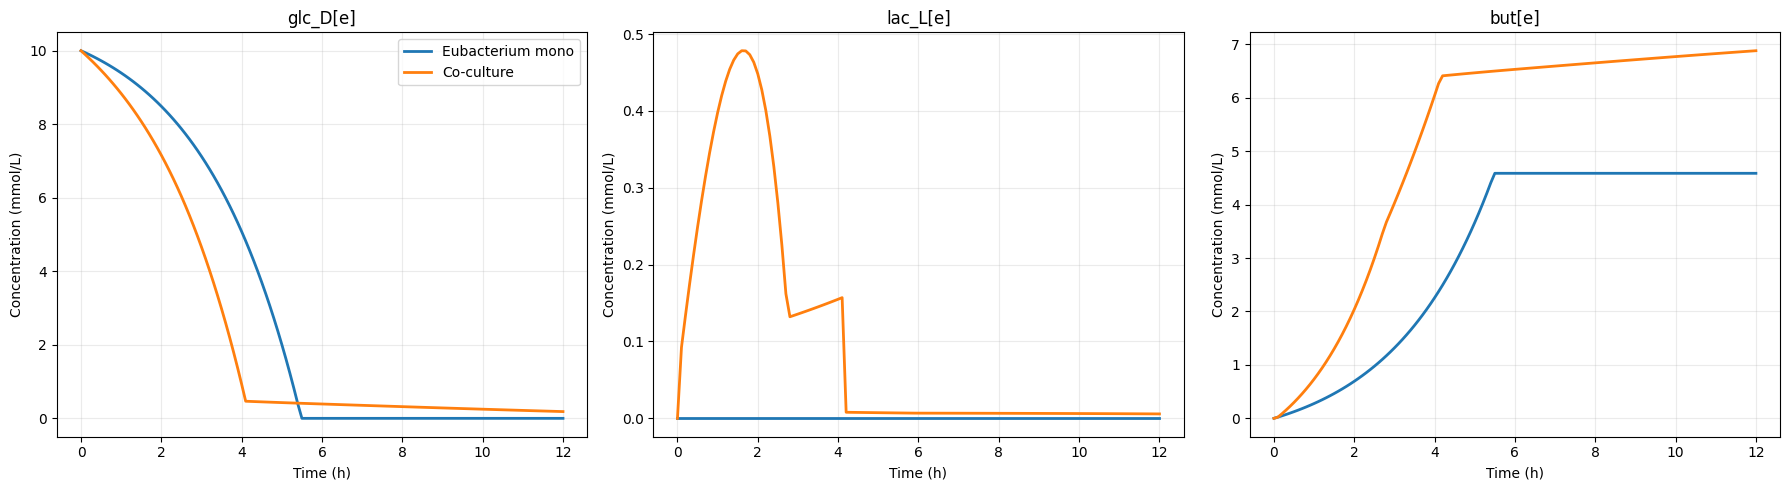

In [12]:
#Plot glucose/lactate/butyrate concentrations side-by-side (mono vs co)
def met_ts(sim, met):
    df = sim.get_metabolite_time_series()
    if met in df.columns:
        return df[met].values
    return np.zeros(len(df))

mets = ['glc_D[e]', 'lac_L[e]', 'but[e]']

media_mono_e = sim_mono_Eubacterium.get_metabolite_time_series()
media_co = sim_co.get_metabolite_time_series()
t_mono_e = np.arange(len(media_mono_e)) * t_step
t_co = np.arange(len(media_co)) * t_step

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, met in zip(axes, mets):
    ax.plot(t_mono_e, met_ts(sim_mono_Eubacterium, met), label='Eubacterium mono', lw=2)
    ax.plot(t_co, met_ts(sim_co, met), label='Co-culture', lw=2)
    ax.set_title(met)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Concentration (mmol/L)')
    ax.grid(alpha=0.25)
axes[0].legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_3724297/1667389503.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  but_total_mono = np.trapz(but_rate_mono, t_mono) if len(but_rate_mono) else 0.0
/tmp/ipykernel_3724297/1667389503.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  but_total_co   = np.trapz(but_rate_co, t_co) if len(but_rate_co) else 0.0


Integrated Eubacterium butyrate from fluxes (mmol/L):
  mono: 4.575280680882193
  co  : 6.867245231016898


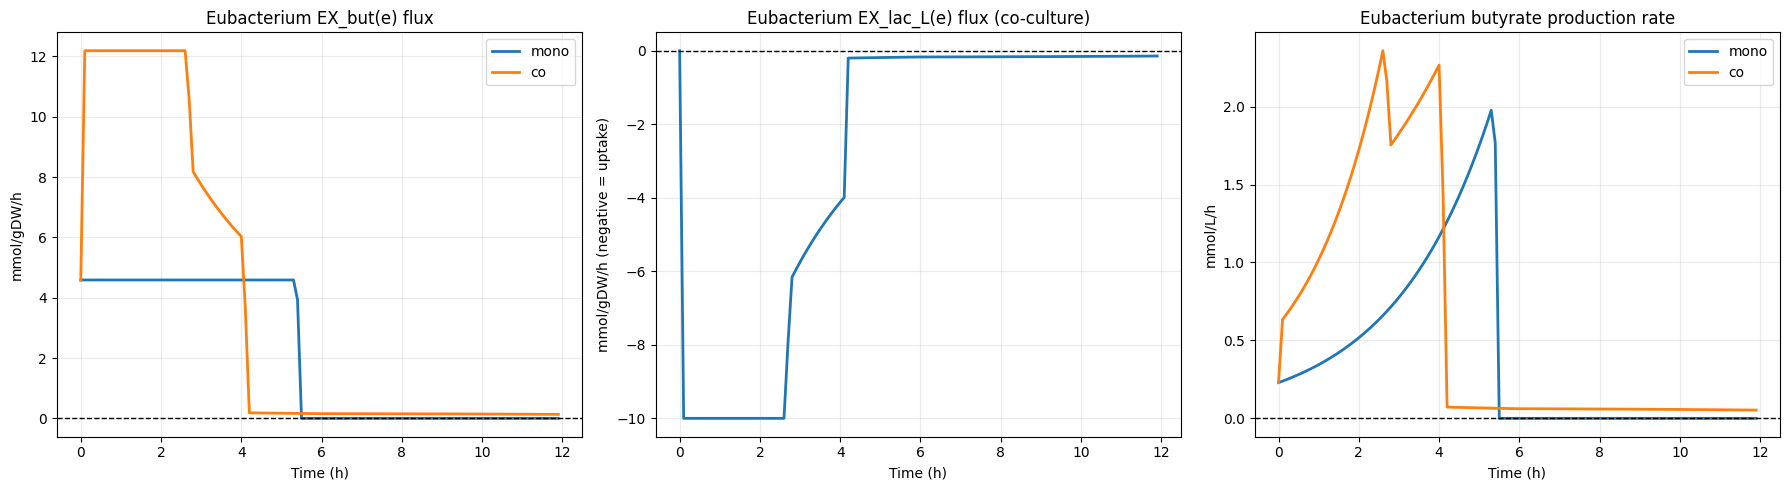

In [13]:
#Plot Eubacterium uptake/production fluxes and compute butyrate per biomass (key sanity check)

def flux_ts(sim, species, ex_rxn, thresh=1e-9):
    f = sim.get_species_exchange_fluxes(species, threshold=thresh)
    if ex_rxn in f.columns:
        return f[ex_rxn].values
    return np.array([])

def biomass_ts(sim, species):
    return sim.total_biomass[species].values

def time_from_len(n, t_step):
    return np.arange(n) * t_step

def rate_mmol_L_h(flux_mmol_gdw_h, biomass_gdw_L):
    n = min(len(flux_mmol_gdw_h), len(biomass_gdw_L))
    return flux_mmol_gdw_h[:n] * biomass_gdw_L[:n]  # mmol/L/h

# Eubacterium-only curves
bio_mono = biomass_ts(sim_mono_Eubacterium, 'Eubacterium')
bio_co   = biomass_ts(sim_co, 'Eubacterium')

but_flux_mono = flux_ts(sim_mono_Eubacterium, 'Eubacterium', 'EX_but(e)')
but_flux_co   = flux_ts(sim_co, 'Eubacterium', 'EX_but(e)')

lac_flux_co   = flux_ts(sim_co, 'Eubacterium', 'EX_lac_L(e)')  # negative = uptake
glc_flux_co   = flux_ts(sim_co, 'Eubacterium', 'EX_glc_D(e)')  # negative = uptake

# Convert butyrate flux -> volumetric production rate
but_rate_mono = rate_mmol_L_h(but_flux_mono, bio_mono)
but_rate_co   = rate_mmol_L_h(but_flux_co, bio_co)

t_mono = time_from_len(len(but_rate_mono), t_step)
t_co   = time_from_len(len(but_rate_co), t_step)

# Integrate to get total produced butyrate (mmol/L) implied by fluxes
but_total_mono = np.trapz(but_rate_mono, t_mono) if len(but_rate_mono) else 0.0
but_total_co   = np.trapz(but_rate_co, t_co) if len(but_rate_co) else 0.0

print("Integrated Eubacterium butyrate from fluxes (mmol/L):")
print("  mono:", but_total_mono)
print("  co  :", but_total_co)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(t_mono, but_flux_mono[:len(t_mono)], lw=2, label='mono')
axes[0].plot(t_co, but_flux_co[:len(t_co)], lw=2, label='co')
axes[0].axhline(0, color='k', ls='--', lw=1)
axes[0].set_title('Eubacterium EX_but(e) flux')
axes[0].set_xlabel('Time (h)')
axes[0].set_ylabel('mmol/gDW/h')
axes[0].grid(alpha=0.25)
axes[0].legend()

t_lac = time_from_len(len(lac_flux_co), t_step)
axes[1].plot(t_lac, lac_flux_co, lw=2)
axes[1].axhline(0, color='k', ls='--', lw=1)
axes[1].set_title('Eubacterium EX_lac_L(e) flux (co-culture)')
axes[1].set_xlabel('Time (h)')
axes[1].set_ylabel('mmol/gDW/h (negative = uptake)')
axes[1].grid(alpha=0.25)

axes[2].plot(t_mono, but_rate_mono[:len(t_mono)], lw=2, label='mono')
axes[2].plot(t_co, but_rate_co[:len(t_co)], lw=2, label='co')
axes[2].axhline(0, color='k', ls='--', lw=1)
axes[2].set_title('Eubacterium butyrate production rate')
axes[2].set_xlabel('Time (h)')
axes[2].set_ylabel('mmol/L/h')
axes[2].grid(alpha=0.25)
axes[2].legend()

plt.tight_layout()
plt.show()